In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('train_0OECtn8.csv')
data_to_predict = pd.read_csv('test_1zqHu22.csv')

display(data.info())
print('*******')
display(data_to_predict.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89197 entries, 0 to 89196
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_id            89197 non-null  int64  
 1   user_id           89197 non-null  int64  
 2   category_id       89197 non-null  int64  
 3   video_id          89197 non-null  int64  
 4   age               89197 non-null  int64  
 5   gender            89197 non-null  object 
 6   profession        89197 non-null  object 
 7   followers         89197 non-null  int64  
 8   views             89197 non-null  int64  
 9   engagement_score  89197 non-null  float64
dtypes: float64(1), int64(7), object(2)
memory usage: 6.8+ MB


None

*******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11121 entries, 0 to 11120
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   row_id       11121 non-null  int64 
 1   user_id      11121 non-null  int64 
 2   category_id  11121 non-null  int64 
 3   video_id     11121 non-null  int64 
 4   age          11121 non-null  int64 
 5   gender       11121 non-null  object
 6   profession   11121 non-null  object
 7   followers    11121 non-null  int64 
 8   views        11121 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 782.1+ KB


None

No missing values present in the datasets. Let's remove row-id and assign correct Dtype to the features.

In [3]:
target_name = 'engagement_score'
target = data[target_name]
data.drop(['row_id', target_name], axis=1, inplace=True)

# id = pd.DataFrame()
# id = data_to_predict['row_id']
data_to_predict.drop(['row_id'], axis=1, inplace=True)

convert_dict = {'user_id': 'object', 'category_id': 'object',
                'video_id': 'object'}

data = data.astype(convert_dict)
data_to_predict  = data_to_predict.astype(convert_dict)

display(data.dtypes)
print('*******')
display(data_to_predict.dtypes)

user_id        object
category_id    object
video_id       object
age             int64
gender         object
profession     object
followers       int64
views           int64
dtype: object

*******


user_id        object
category_id    object
video_id       object
age             int64
gender         object
profession     object
followers       int64
views           int64
dtype: object

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

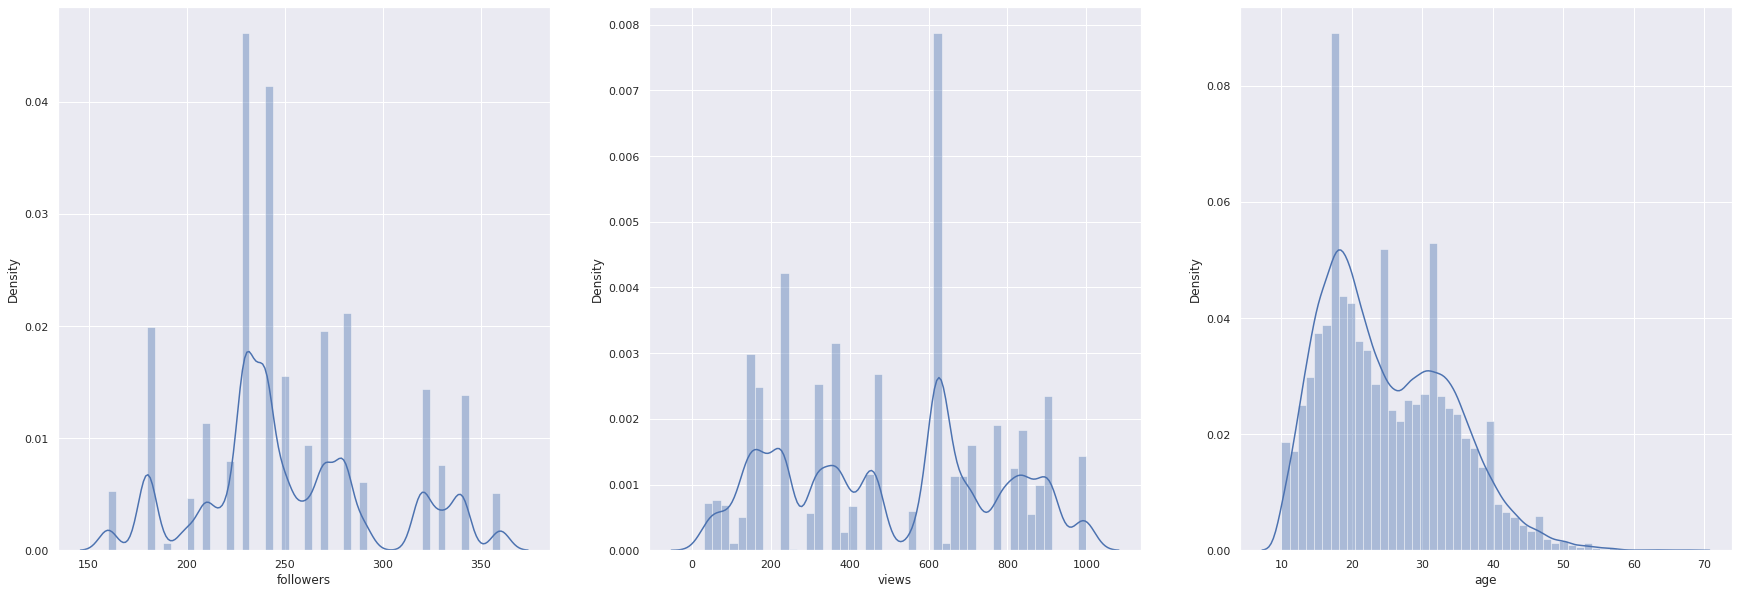

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
sns.distplot(data['followers'], kde=True)
plt.subplot(1, 3, 2)
sns.distplot(data['views'], kde=True)
plt.subplot(1, 3, 3)
sns.distplot(data['age'], kde=True)
plt.show()

In [5]:
from sklearn.compose import make_column_selector as selector

num_col_selector = selector(dtype_exclude=object)
cat_col_selector = selector(dtype_include=object)

num_feat = num_col_selector(data)
cat_feat = cat_col_selector(data)

In [6]:
# arranging the columns so that index can be fetched easily for transformation purposes
X = data[num_feat + cat_feat]
to_predict = data_to_predict[num_feat + cat_feat]

In [7]:
# getting num and cat features index
num_feat_end = len(num_feat)
cat_feat_end = num_feat_end + len(cat_feat)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

scalar = RobustScaler(with_centering=False)
ohe = OneHotEncoder(handle_unknown='ignore')

#  it is suggested to pass the index of columns rather than its name because after transformation it’s converted into Numpy Array and the array does not have any column names.
cat_trf = ColumnTransformer(
    [('Nominal', ohe, [x for x in range(num_feat_end, cat_feat_end)])], remainder='passthrough') # categorical feature transformer

num_trf = ColumnTransformer(
    [('Scalar', scalar, [x for x in range(num_feat_end)])], remainder='passthrough') # numerical feature transformer

preprocessor = make_pipeline(cat_trf, num_trf) # data preprocessor pipeline

data_train, data_test, target_train, target_test = train_test_split(
    X, target, test_size=0.1, random_state=42)

In [9]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# model = make_pipeline(clone(preprocessor), Ridge())

# Ridge_param = {
#     'ridge__solver': ['cholesky'],
#     'ridge__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
#     'ridge__fit_intercept': [False]
#     'ridge__normalize': [True, False]
# }

# R = GridSearchCV(model, Ridge_param, cv=5, n_jobs=-1)
R = make_pipeline(clone(preprocessor), Ridge(alpha=1, fit_intercept=False, solver='cholesky')) # Parameters taken from previous hyperparameter tuning
R.fit(data_train, target_train)
# R_best= R.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer-1',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Nominal',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   [3, 4, 5, 6,
                                                                    7])])),
                                 ('columntransformer-2',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Scalar',
                                                                   RobustScaler(with_centering=False),
                                                                   [0, 1,
                                                                    2])]))])),
                ('ridge',
   

In [12]:
from lightgbm import LGBMRegressor

# model_LGB = make_pipeline(clone(preprocessor), LGBMRegressor())

# LGB_param = {
#     'lgbmregressor__boosting_type': ['gbdt'],
#     'lgbmregressor__learning_rate': [0.1]
# }

# LGB = GridSearchCV(model_LGB, LGB_param, cv=5)
LGB = make_pipeline(clone(preprocessor), LGBMRegressor(boosting_type='gbdt', learning_rate=0.1)) # Parameters taken from previous hyperparameter tuning
LGB.fit(data_train, target_train)
# LGB_best = LGB.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer-1',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Nominal',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   [3, 4, 5, 6,
                                                                    7])])),
                                 ('columntransformer-2',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Scalar',
                                                                   RobustScaler(with_centering=False),
                                                                   [0, 1,
                                                                    2])]))])),
                ('lgbmregress

In [13]:
from xgboost import XGBRegressor

# model_XGB = make_pipeline(clone(preprocessor), XGBRegressor())

# XGB_param = {
#         'xgbregressor__min_child_weight': [1, 5],
#         'xgbregressor__eta': [0.1, 0.3, 0.5],
#         'xgbregressor__gamma': [0, 0.2, 0.5],
#         'xgbregressor__subsample': [0.5, 1.0],
#         'xgbregressor__max_depth': [3, 6, 8],
#         'xgbregressor__tree_method': ['auto']
#         }

# XGB = GridSearchCV(model_XGB, XGB_param, cv=5)

XGB = make_pipeline(clone(preprocessor), XGBRegressor(eta=0.5, gamma=0, max_depth=8, min_child_weight=1, subsample=1.0, tree_method='auto')) # Parameters taken from previous hyperparameter tuning
XGB.fit(data_train, target_train)
# XGB_best = XGB.best_estimator_
# XGB_best

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer-1',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Nominal',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   [3, 4, 5, 6,
                                                                    7])])),
                                 ('columntransformer-2',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Scalar',
                                                                   RobustScaler(with_centering=False),
                                                                   [0, 1,
                                                                    2])]))])),
                ('xgbregresso

In [16]:
models = [R, LGB, XGB]
model_names = ['R', 'LGB', 'XGB']

In [17]:
from sklearn.metrics import r2_score

out = pd.DataFrame(target_test)
R2 = pd.DataFrame()

for i, m in enumerate(models):
    sub = pd.read_csv('sample_submission_JPlpRcN.csv').drop(['engagement_score'], axis=1)
#     print(f'{model_names[i]} best score: {m.best_score_}')
#     print(f'{model_names[i]} best parameters: {m.best_params_}')
#     print('-----------------------------------------------')
    out[f'Pred_{model_names[i]}'] = m.predict(data_test)
    out[f'Residual_{model_names[i]}'] = out[target_name] - out[f'Pred_{model_names[i]}']
    out[f'%Diff_{model_names[i]}'] = np.absolute(out[f'Residual_{model_names[i]}']/out[target_name]*100)
    R2[model_names[i]] = [r2_score(out[target_name], out[f'Pred_{model_names[i]}'])]
    sub['engagement_score'] = m.predict(to_predict)
    sub.to_csv(f'my submission {model_names[i]}.csv', index=False)

In [18]:
# imp = [col for col in out.columns if '%Diff_' in col]
display(out.describe())
display(R2)

,engagement_score,Pred_R,Residual_R,%Diff_R,Pred_LGB,Residual_LGB,%Diff_LGB,Pred_XGB,Residual_XGB,%Diff_XGB
count,8920.000000,8920.000000,8920.000000,8920.000000,8920.000000,8920.000000,8920.000000,8920.000000,8920.000000,8920.000000
mean,3.480099,3.492093,-0.011995,inf,3.486782,-0.006683,inf,3.495874,-0.015813,inf
std,0.870743,0.624551,0.642431,NaN,0.513620,0.694104,NaN,0.513338,0.685976,NaN
min,0.000000,0.909450,-3.530638,0.001322,1.835970,-3.638616,0.001297,1.346614,-3.668795,0.002375
25%,2.880000,3.084421,-0.338486,4.445867,3.135792,-0.335033,5.621967,3.166614,-0.340084,5.803387
50%,3.700000,3.552141,0.037464,9.977672,3.542311,0.069380,10.580796,3.579655,0.061076,10.419926
75%,4.160000,3.957189,0.369635,19.869826,3.938643,0.425368,20.575398,3.985016,0.412082,20.381018
max,5.000000,5.118041,3.012074,inf,4.552734,2.322400,inf,4.747457,2.362833,inf


,R,LGB,XGB
0,0.455467,0.364509,0.379032


<AxesSubplot:>

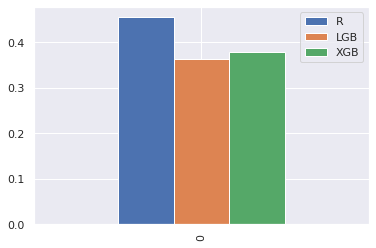

In [19]:
R2.plot.bar()